In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import json

from feature_extractor import FeatureExtractor

## get label distribution

In [2]:
anno_dict = pickle.load(open('/workspace/pvc-meteor/features/annotations.pickle', 'rb'))
# anno_dict['REC_2020_10_12_03_08_38_F.MP4']['feature_length'] == anno_dict['REC_2020_10_12_03_08_38_F.MP4']['anno'].shape[0]

In [3]:
total_frames = 0
cat_array = np.zeros((7,))
unannoted_frames = 0

for name in tqdm(anno_dict.keys()):
    total_frames += anno_dict[name]['feature_length']
    annotation = anno_dict[name]['anno']
    new_cat = np.sum(annotation, axis=0)
    unannoted_frames += anno_dict[name]['feature_length'] - np.any(annotation, axis=1).sum()

    cat_array = cat_array + new_cat


100%|██████████| 1213/1213 [00:00<00:00, 14475.87it/s]


In [4]:
cat_names = ['Over Taking', 'Over Speedign', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']

cat_array, total_frames, unannoted_frames

(array([2.81774e+05, 3.42000e+02, 9.05710e+04, 5.18000e+02, 3.65120e+04,
        2.13000e+02, 9.48200e+03]),
 985746,
 622239)

## visualize class distribution

Text(0.5, 1.0, 'Distribution of frames per category, Logscaled')

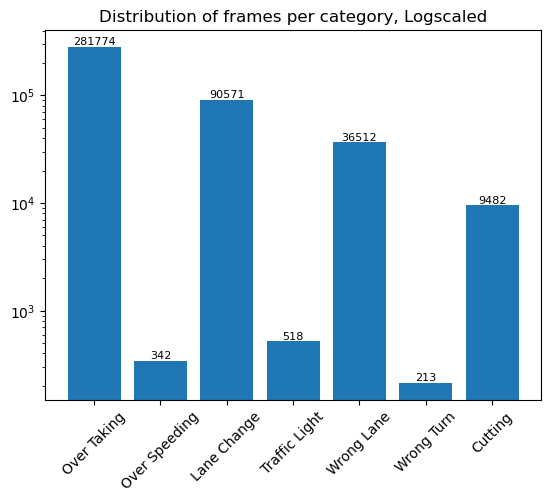

In [5]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
cat_names = ['Over Taking', 'Over Speeding', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']


ax.bar(cat_names, cat_array)

# Add annotations to each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, 
            str(int(height)),
            ha='center', va='bottom', rotation=0, color='black', fontsize=8)

plt.xticks(rotation = 45)
plt.title('Distribution of frames per category, Logscaled')

### analyse test and train set seperately.

In [6]:
json_file = json.load(open('../../pvc-meteor/features/METEOR_info.json', 'r'))['METEOR']

In [7]:
train_vid_names = json_file['train_session_set']
test_vid_names = json_file['test_session_set']

test_class_counts = np.zeros((7))
for vid_name in test_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    test_class_counts = test_class_counts + np.sum(curr_anno, axis=0)
    
train_class_counts = np.zeros((7))
for vid_name in train_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    train_class_counts = train_class_counts + np.sum(curr_anno, axis=0) 

,test_f,train_f,abs_frames,rel_test
OverTaking,57700.0,224074.0,281774.0,0.204774
Overspeeding,0.0,342.0,342.0,0.000000
LaneChange,17235.0,73336.0,90571.0,0.190293
TrafficLight,0.0,518.0,518.0,0.000000
WrongLane,6373.0,30139.0,36512.0,0.174545
WrongTurn,36.0,177.0,213.0,0.169014
Cutting,1998.0,7484.0,9482.0,0.210715


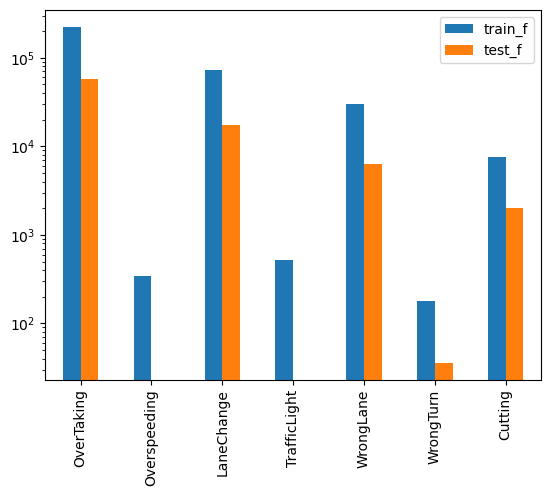

In [8]:
df = pd.DataFrame(
    data=np.column_stack((test_class_counts, train_class_counts)),
    columns=['test_f', 'train_f'],
    index = json_file['class_index']
)
'''
df = (df
    .assign(abs_frames = df['test_f'] + df['train_f'])
    .assign(rel_test = df['test_f'] / df['abs_frames'])
)
'''
df = df.assign(abs_frames = df['test_f'] + df['train_f'])
df = df.assign(rel_test = df['test_f'] / df['abs_frames'])



ax = df[['train_f', 'test_f']].plot(kind='bar', stacked=False)
ax.set_yscale('log')

df

### find split so that all classes are part of both sets.

- count frames per class per video
- select videos so that 20% of each class are part of test set. Rest is train.

In [12]:
def more_perfect_split(anno_data, info_json, categories, train_split = 0.8):
    # 1. select category with fewest samples
    # 2. split this category, so that 20% test; 80% train
    # 3. select next most infrequent category --> check if frames from this are already in train/test set
    # 4. split this category so that ~20% test; ~80% train
    # 5. if not all categories processed: --> back to 3; else return set 
    
    # transform categories to indices
    indices = []
    for i, name in enumerate(info_json['class_index']):
        if name in categories:
            indices.append(i)
    
    # get label_distribution per video:
    dist_df = pd.DataFrame(data=None, columns=categories)
    for name in anno_data.keys():
        anno_data = anno_dict[name]['anno'][:,indices].sum(axis=0)
        temp_df = pd.DataFrame(data = [anno_data], columns=categories, index = [name])
        dist_df = pd.concat([dist_df, temp_df], axis=0)
    
    # order columns by frequency --> infrequent first
    cat_by_freq = list(dist_df.sum().sort_values(ascending=True).index)

    # set up dataframe to store training data
    train_df = pd.DataFrame(data=None, columns=categories)

    # keep track of columns where 80% target is already satisfied
    satisfied_columns = []

    # iterate through categories, starting with most infrequent ones.    
    for cat in cat_by_freq:
        total_frames = dist_df.loc[:, cat].sum()
        abs_train_frames = int(total_frames * train_split)
        vid_list = list(dist_df.loc[dist_df.loc[:, cat] > 0, cat].index)

        # get cat_df 
        cat_df = dist_df.loc[vid_list,:].sort_values(cat, ascending=False)
        # filter cat_df: only keep videos that don't have frames for satisfied cats
        if len(satisfied_columns) > 0:
            cat_df = cat_df.loc[cat_df.loc[:, satisfied_columns].sum(axis=1) == 0, :]

        _idx = 0
        while train_df.loc[:, cat].sum() < abs_train_frames:
            train_df = pd.concat([train_df, pd.DataFrame(cat_df.iloc[_idx, :]).T], axis=0)

            # alternate between longest and shortest video to add.
            _idx = 0 if _idx == -1 else -1

        satisfied_columns.append(cat)

        print(train_df.sum(axis=0).values / dist_df.sum(axis=0).values)



df = more_perfect_split(anno_dict, json_file, ['OverTaking', 'LaneChange', 'WrongLane', 'Cutting'])


Cutting
0
303.0
304.0
607.0
608.0
911.0
912.0
1215.0
1216.0
1519.0
1520.0
1823.0
1824.0
2127.0
2128.0
2431.0
2432.0
2735.0
2736.0
3039.0
3040.0
3343.0
3344.0
3647.0
3648.0
3951.0
3952.0
4255.0
4256.0
4559.0
4560.0
4863.0
4864.0
5167.0
5168.0
5471.0
5472.0
5775.0
5776.0
6079.0
6080.0
6383.0
6384.0
6687.0
6688.0
6991.0
6992.0
7295.0
7296.0
[0.03451348 0.06100187 0.         0.8014132 ]
WrongLane
0.0
736.0
741.0
1477.0
1482.0
2218.0
2223.0
2959.0
2964.0
3700.0
3705.0
4441.0
4446.0
5182.0
5187.0
5923.0
5928.0
6664.0
6669.0
7405.0
7410.0
8146.0
8151.0
8887.0
8892.0
9628.0
9633.0
10369.0
10374.0
11110.0
11115.0
11851.0
11856.0
12592.0
12597.0
13333.0
13338.0
14074.0
14079.0
14815.0
14820.0
15556.0
15561.0
16297.0
16302.0
17038.0
17043.0
17779.0
17784.0
18520.0
18525.0
19261.0
19266.0
20002.0
20007.0
20743.0
20748.0
21484.0
21489.0
22225.0
22230.0
22966.0
22971.0
23707.0
23712.0
24448.0
24453.0
25189.0
25194.0
25930.0
25935.0
26671.0
26676.0
27412.0
27417.0
28153.0
28158.0
28894.0
28899.0
[0.1

In [ ]:
df

# analyse second round of extacted features

In [2]:
file = pickle.load(open('/workspace/pvc-meteor/features/extraction_output_10-02-2023-05-22.pkl', 'rb'))
file.keys()

dict_keys(['meta', 'features', 'annotations', 'error_file'])

In [5]:
file['annotations']

{}

In [21]:
df.iloc[4,:].loc['train_f']

30139.0